# Phase and Magnitude Detection Demo
<br>
<br>
AWESEM Signal Processing
<br>
<br>
Erick Blankenberg, 5/28/2019

---

The goal of this demo is to find the phase and magnitude distortion of the scanning stage for a set of data taken with a sinusoidal driving waveform of a fixed frequency. If this can be done consistently over a wide range of frequencies we can then characterize the sample stage and predict the driven motion for an arbitrary driving waveform or craft a driving waveform to obtain a desired frequency response if we assume that the system can be modeled as a linear time-invariant system.
<br>
<br>
In the first portion below we import one limited "Modern Art" image to be analyzed. This image is created by taking data collected with a sinusoidal driving waveform along the fast axis and no driving waveform along the slow axis and constructing the image assuming that the driven waveform is a ramp. This is equivalent to just stacking the inbound time-stamped data.
<br>
<br>
TODO review driver waveform

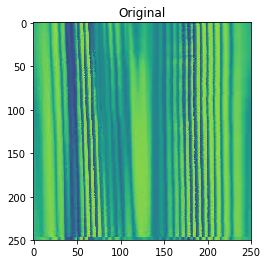

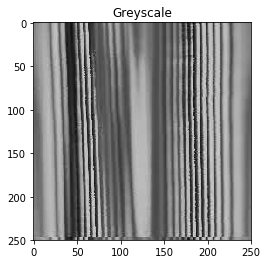

In [123]:
# Libraries
from   math import floor 
import numpy
import imageio
from   scipy       import ndimage
from   scipy       import misc
from   scipy       import signal
from skimage       import data
from skimage.color import rgb2gray
import skimage.filters as filters

from   matplotlib import cm
from   matplotlib import pyplot

# Imports limited "Modern Art" image.

originalImage  = imageio.imread('Phase_3.jpg')
pyplot.imshow(originalImage)
pyplot.title('Original')
pyplot.show()

grayScaleImage = rgb2gray(originalImage)
pyplot.imshow(grayScaleImage, cmap= pyplot.cm.gray)
pyplot.title('Greyscale')
pyplot.show()

---
The approach below uses the simple symmetry detection method along a known coordinate axis described in https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570347823.pdf. Namely computing the auto-convolution and normalizing to the total energy of the signal in the range of interest. 
<br>
<br>
In this case we are interested in the overall symmetry of the modern art image along the target coordinate axis with wraparound as the driving sinusoidal waveform is periodic and the assumed response waveform is as well. We implement this as a moving patch to determine the reflection axis as follows:

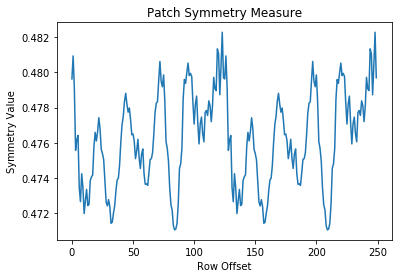

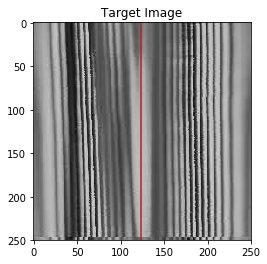

In [101]:
targetImage = grayScaleImage
# COMBAK repeated symmetry vals may be a bug?
# Evaluates symmetry along rows for the given patch
def evaluatePatchVerticalSymmetry(image, columnLeft, columnRight, rowTop, rowBottom):
    # Finds numerator
    numeratorAccumulator = 0
    for currentTargetRow in range(rowTop, rowBottom):
        for currentColumnOffset in range(0, abs(columnLeft - columnRight)):
            numeratorAccumulator += image[currentTargetRow, columnLeft + currentColumnOffset] * image[currentTargetRow, columnRight - currentColumnOffset]
            
    totalEnergy = numpy.sum(image * image)
    return numeratorAccumulator / totalEnergy

# Pads image with itself to emulate wraparound
imageDoubled = numpy.tile(targetImage, (1, 2))

symmetryVals = numpy.zeros((targetImage.shape[1]))
for currentStartColumn in range(0, targetImage.shape[1]):
    symmetryVals[(currentStartColumn + (int) (floor(targetImage.shape[1] / 2.0))) % (targetImage.shape[1])] = evaluatePatchVerticalSymmetry(imageDoubled, currentStartColumn, currentStartColumn + targetImage.shape[0], 0, targetImage.shape[1])
    
# Shows symmetry measure as a function of row index
pyplot.plot(symmetryVals)
pyplot.title('Patch Symmetry Measure')
pyplot.xlabel('Row Offset')
pyplot.ylabel('Symmetry Value')
pyplot.show()

# Plots image with maximum symmetry lines marked
maxIndex = numpy.argmax(symmetryVals)
pyplot.imshow(targetImage, cmap= pyplot.cm.gray, zorder = 1)
pyplot.title('Target Image')
ymin, ymax = pyplot.gca().get_ybound()
pyplot.plot([maxIndex, maxIndex], [ymin, ymax], color = 'fireBrick', zorder = 2)
pyplot.show()



We now know the data offset corresponding to a crest or trough in the waveform. We can now map the driving waveform displacement as a function of index in the modern art image along the rows as follows:

TODO can we isolate crest / trough?

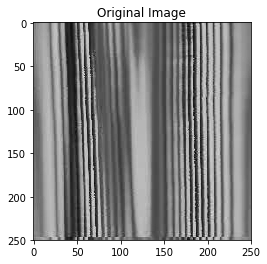

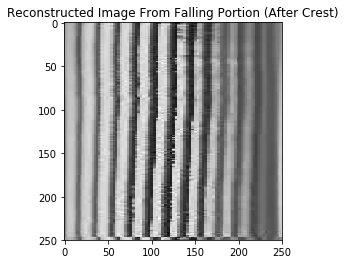

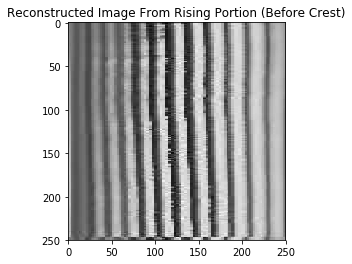

In [197]:
pyplot.imshow(targetImage, cmap= pyplot.cm.gray)
pyplot.title('Original Image')
pyplot.show()

# We are going to use the crest as a reference point at zero and assume a cosine displacement waveform
# > COMBAK:
#    - Need to interpolate as to not produce jagged transitions
offsetToCrest = maxIndex
rebuiltImageFalling = numpy.zeros(targetImage.shape)
rebuiltImageRising  = numpy.zeros(targetImage.shape)
targetColumnsFalling = numpy.zeros((targetImage.shape[1]))
targetColumnsRising = numpy.zeros((targetImage.shape[1]))
for currentColumn in range(targetImage.shape[1]):
    targetColumnFallingFloat = ((numpy.arccos(((currentColumn * 2.0) / targetImage.shape[1]) - 1) * targetImage.shape[1] / (2.0 * numpy.pi)) + offsetToCrest) % targetImage.shape[1]
    targetColumnRisingFloat  = ((offsetToCrest - targetColumnFalling) + targetImage.shape[1]) % targetImage.shape[1]
    rebuiltImageFalling[:, currentColumn] = targetImage[:, targetColumnFalling]
    rebuiltImageRising[:, currentColumn]  = targetImage[:, targetColumnRising]
    targetColumnsFalling[currentColumn] = targetColumnFalling
    targetColumnsRising[currentColumn] = targetColumnRising
    
pyplot.imshow(rebuiltImageFalling, cmap= pyplot.cm.gray)
pyplot.title('Reconstructed Image From Falling Portion (After Crest)')
pyplot.show()

pyplot.imshow(rebuiltImageRising, cmap= pyplot.cm.gray)
pyplot.title('Reconstructed Image From Rising Portion (Before Crest)')
pyplot.show()

# Plots mappings
#pyplot.plot(targetColumnsRising)
#pyplot.show()
#pyplot.plot(targetColumnsFalling)
#pyplot.show()

We can now estimate the magnification of these samples given that we know the dimensions of cells in the original grating. We first need to isolate the bars.
<br>
<br>
*Note that it is ok if there are very short bars, we only care about the width of the bars. The bars may be cut up if the scan is disrupted midway through a slow scan.*

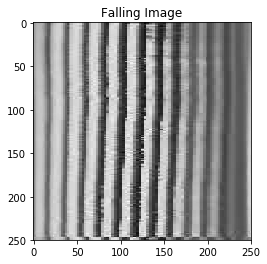

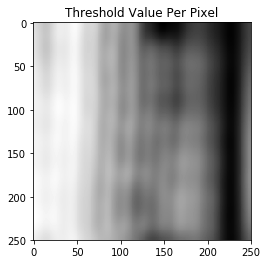

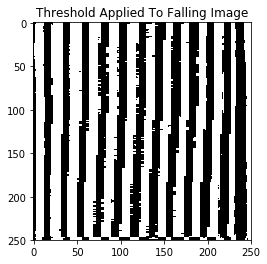

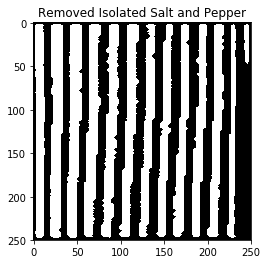

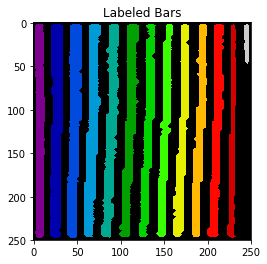

Unique Bars: 13


In [195]:
# Applies thresholding to image to isolate bars
# > Source image
pyplot.imshow(rebuiltImageFalling, cmap= pyplot.cm.gray)
pyplot.title('Falling Image')
pyplot.show()
# > Uses local thresholding to normalize to regional variances in brightness
thresholdedVals = filters.threshold_local(rebuiltImageFalling, block_size = 55) # Local region should span about 4 bars (you should not really be able to distinguish bars in filter)
pyplot.imshow(thresholdedVals, cmap= pyplot.cm.gray)
pyplot.title('Threshold Value Per Pixel')
pyplot.show()
# > Just with threshold applies 
# COMBAK: 
#  - maybe we should do iterative thresholding depending on initial width of bars to account for different magnifications
#  - Bars that touch the borders should be removed as they are clipped
#  - Maybe sort bars out by other factors like straightness or use an edge detection thersholding technique? Currently skinny bars getting through
thresholdedImage = rebuiltImageFalling > thresholdedVals
pyplot.imshow(thresholdedImage, cmap= pyplot.cm.gray)
pyplot.title('Threshold Applied To Falling Image')
pyplot.show()
# > Remove small unconnected regions
for currentOperation in range(0, 5):
    thresholdedImage = ndimage.binary_opening(thresholdedImage, iterations = 2) # Remove salt
    thresholdedImage = ndimage.binary_closing(thresholdedImage, iterations = 2) # Remove pepper
pyplot.imshow(thresholdedImage, cmap= pyplot.cm.gray)
pyplot.title('Removed Isolated Salt and Pepper')
pyplot.show()

# Identifies the bars
labeled_bars, numBars = ndimage.label(thresholdedImage)

pyplot.imshow(labeled_bars, cmap = pyplot.cm.nipy_spectral)
pyplot.title('Labeled Bars')
pyplot.show()

print("Unique Bars: %d" % (numBars))


We can now run statistics on the widths of the bars to determine the scaling.

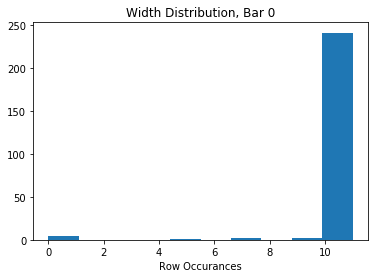

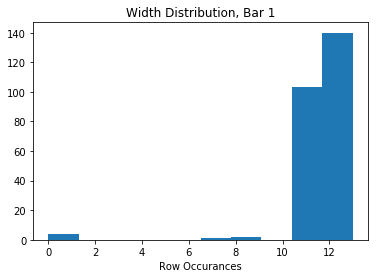

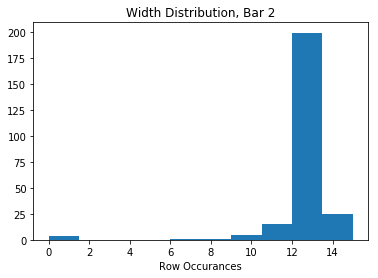

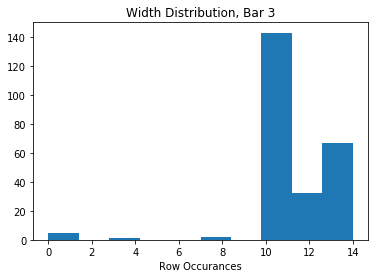

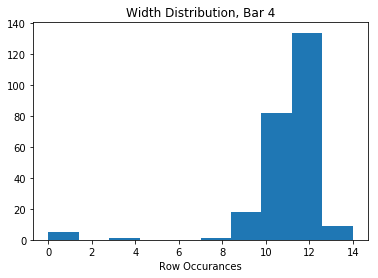

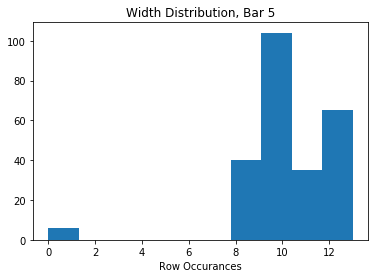

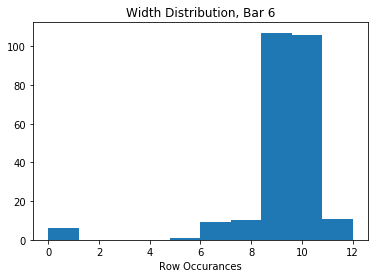

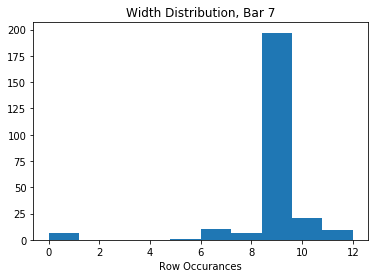

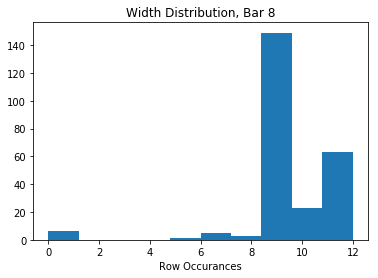

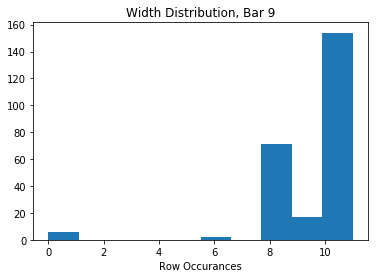

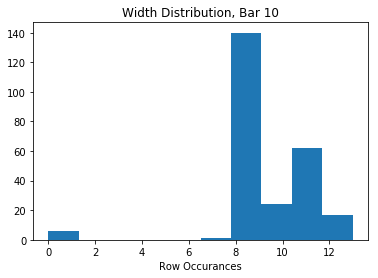

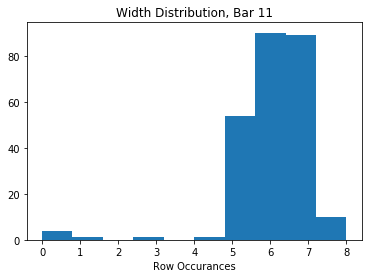

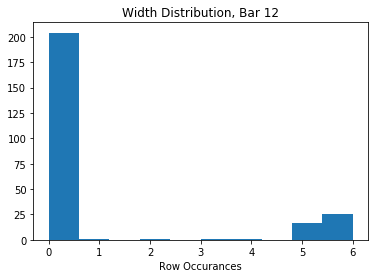

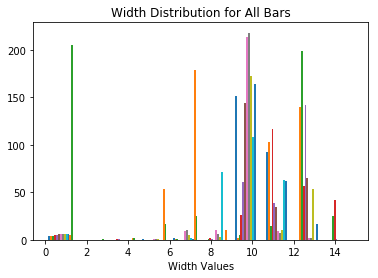

Median Value: 10.0


In [196]:
# Gets width of cells one row at a time
rowStats = numpy.zeros((labeled_bars.shape[0], numBars))
for currentRow in range(0, labeled_bars.shape[0]):
    targetRowVals = labeled_bars[currentRow, :]
    for currentBar in range(0, numBars):
        rowStats[currentRow, currentBar] = numpy.sum(targetRowVals == (currentBar + 1))  # Bars labeled 1..numBars inclusive

# Plots histograms for each bar
for currentBar in range(0, numBars):
    pyplot.hist(rowStats[:, currentBar])
    pyplot.title("Width Distribution, Bar %s" % (currentBar))
    pyplot.xlabel('Width Values')
    pyplot.xlabel('Row Occurances')
    pyplot.show()
    
# Plots histogram for all bars
pyplot.hist(rowStats)
pyplot.title("Width Distribution for All Bars")
pyplot.xlabel('Row Occurances')
pyplot.xlabel('Width Values')
pyplot.show()

As a result we have the following:

In [201]:
medianWidth = numpy.median(rowStats)

print("Median Value: %s" % (medianWidth))

PhysicalCellWidth = 5.08 # Microns

MicronsPerPixel = PhysicalCellWidth / medianWidth
MicronsDimensions = MicronsPerPixel * numpy.asarray(targetImage.shape)

print("Image dimensions in microns: %s" % (MicronsDimensions))


Median Value: 10.0
Image dimensions in microns: [127. 127.]


---
Some of our older "modern art" images were taken with sinusoidal driving waveforms along both axis. As before we assume that the system is LTI and find the phase and magnitude distortions for each axis and reconstruct.

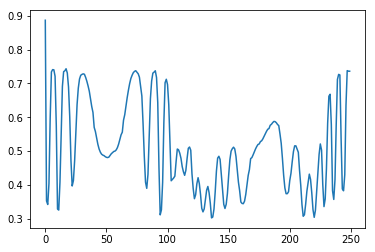

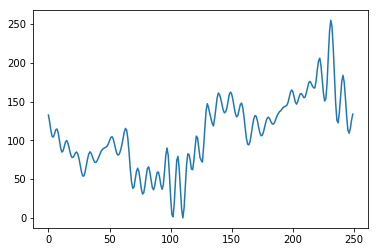

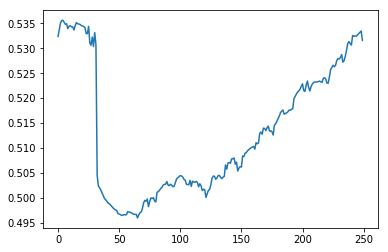

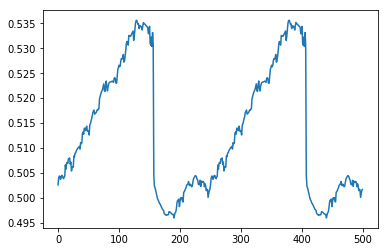

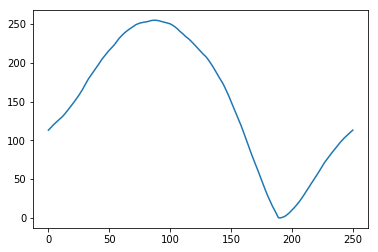

In [3]:
import numpy    as     np
from   scipy    import signal
from   scipy    import ndimage

# Finds correlation of image with reversed version along each
# axis for symmetry detection

imageSize = np.shape(grayScaleImage) # Exports as (height, width, depth)

"""
verticalConvolutions = np.zeros((imageSize[0], imageSize[1]));
for horizontalIndex in range(imageSize[1]):
    targetColumn  = grayScaleImage[:, horizontalIndex]
    patternColumn = targetColumn
    # Pads targetColumn to emulate wraparound
    patternConcatenatedColumn  = np.concatenate([targetColumn[int(round(imageSize[1]/2.0)):], targetColumn, targetColumn[:-int(round(imageSize[1]/2.0))]])
    # Preforms convolution
    convolutionColumn = np.convolve(targetColumn, patternConcatenatedColumn, mode = 'valid')
    convMax = np.amax(convolutionColumn)
    convMin = np.amin(convolutionColumn)
    convolutionColumn = ((convolutionColumn - convMin) / (convMax - convMin)) * 255
    verticalConvolutions[:, horizontalIndex] = convolutionColumn[:-1]

pyplot.imshow(verticalConvolutions, cmap = pyplot.cm.viridis)
pyplot.title('Symmetry across Vertical Axis')
pyplot.show()
"""

compressedColumn = np.average(grayScaleImage, axis = 1)
pyplot.plot(compressedColumn)
pyplot.show()

# Pads targetColumn to emulate wraparound
patternConcatenatedColumn  = np.concatenate([compressedColumn[int(round(imageSize[1]/2.0)):], compressedColumn, compressedColumn[:-int(round(imageSize[1]/2.0))]])
# Preforms convolution
convolutionColumn = ndimage.filters.convolve1d(compressedColumn, compressedColumn, mode = 'wrap')
convMax = np.amax(convolutionColumn)
convMin = np.amin(convolutionColumn)
convolutionColumn = ((convolutionColumn - convMin) / (convMax - convMin)) * 255
pyplot.plot(convolutionColumn)
pyplot.show()
    
"""
# Reverses image along vertical axis and runs correlation through every row
horizontalCorrelations = np.zeros((imageSize[0], imageSize[1]))
for verticalIndex in range(imageSize[0]):
    targetRow = thresholdedImage[verticalIndex, :]
    patternRow = targetRow #np.flipud(targetRow)
    # Pads for wraparound
    targetRow = np.concatenate((targetRow, targetRow, targetRow), axis = 0)
    # Preforms correlation
    correlationRow = np.correlate(targetRow, patternRow, mode = 'same')
    horizontalCorrelations[verticalIndex, :] = correlationRow[(int(imageSize[1] * 1.5)):(int(imageSize[1] * 2.5))]
    
pyplot.imshow(horizontalCorrelations, cmap = pyplot.cm.gray)
pyplot.title('Symmetry across Vertical Axis')
pyplot.show()
"""

compressedRow = np.average(grayScaleImage, axis = 0)
compressedRow = np.roll(compressedRow, 25)
pyplot.plot(compressedRow)
pyplot.show()

# Pads targetColumn to emulate wraparound
patternConcatenatedRow  = np.concatenate([compressedRow[int(round(imageSize[0]/2.0)):], compressedRow, compressedRow[:-int(round(imageSize[0]/2.0))]])
pyplot.plot(patternConcatenatedRow)
pyplot.show()
# Preforms convolution
convolutionRow = np.convolve(compressedRow, patternConcatenatedRow, mode = 'valid')
convMax = np.amax(convolutionRow)
convMin = np.amin(convolutionRow)
convolutionRow = ((convolutionRow - convMin) / (convMax - convMin)) * 255
pyplot.plot(convolutionRow)
pyplot.show()

I had initially considered trying to find the current phase offset for a full "modern-art" image as this would allow the user to set an arbitrary frequency for both axis and calibrate in one step. However, as once we characterized the stage it would no longer be necessary for the user to manually calibrate the stage for every setting they chose, I decided not to pursue this. If it ever becomes necessary in the future I found this helpful paper:https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570347823.pdf
<br>
<br>
The approach is derived from 1d signal processing techniques and seeks to maximize the even part of the signal for a 1-d sequence by use of auto-convolution normalized to the total energy of the signal over the region of interest. The paper extended this further by applying windowing to seek local regions of symmetry and into two dimensions.